# Week 11: Networks 3 (epidemiology)


While researchers have been modeling the spread of diseases and information for many years, the COVID-19 pandemic playing out right now puts a new emphasis on the importance of being able to model (and thus predict) how diseases propagate through populations. So how do you most effectively model the spread of a disease? There are many^ ways, and all of them (at least the useful ones) involves networks. In this notebook you will get your hands on a couple different modeling approaches. Specifically:

* Spreading processes on static networks
* Spreading processes on temporal networks
* Metapopulation models

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import networkx as nx
import netwulf as nw
from matplotlib import gridspec
from matplotlib.lines import Line2D

## Exercises

In a *contact network* nodes are people and links represent interactions that can happen between people. You can use such a network as a *substrate* for simulating the spreading of "something". Spreading of what? That's up to you. It can be a disease, a behavior, a piece of information, anything you can imagine people may pass along. There's a whole subfield of Network Science which deals with this, but the fundamental idea is actually quite simple:

> Nodes that are connected can transmit this "something" with a probability. Each timestep of the simulation is an opportunity for the "something" to spread.

You can then make this more nuanced by adding extra criteria for transmission. For disease modeling these can e.g. be that nodes can only be infected after multiple exposures or if multiple neighbors are infected, that they can be cured and become resistant/susceptible with some probability, that they may die and exit the simulation creating a void in the network, that becoming infected makes them change their links, that godzilla walks in and eats everyone—the possibilities are endless and you decide which rules exist in the simulation universe.

Generally speaking, there are four major classes of so-called "compartmental models" in network epidemiology:
* *Susceptible-Infected (SI)*: Nodes are susceptible at start, and once they are infected they never recover. This models spreading of unforgetable information, or diseases that people get and pass on, and never recover from (like HIV, herpes, etc.).
* *Susceptible-Infected-Susceptible (SIS)*: Nodes are susceptible, then get infected and stay infected for some time, then get susceptible again, an the cycle continues. This could model things like the flu which comes and goes and you get and recover from over and over again.
* *Susceptible-Infected-Resistant (SIR)*: Nodes become infected and after some time they gain resistance so that they can niether become infected nor spread disease/information further. Once they are resistant they are essentially "removed" from the network, so this type of model works for diseases where people recover and gain resistance as well as ones that kill people, as niether type of person can transmit (measles, chickenpox but also rabies, Creutzfeldt–Jakob disease, etc.).
* *Susceptible-Infected-Resistant-Susceptible (SIRS)*: Probably self-explanatory if you understood the above.

The idea that drives the "compartmenal" modeling approach is that within a population you can assign each
individual to a compartment based on their "state" (infected, susceptible, etc.). When you start the simulation,
individuals then flow between compartments with specific flow rates.

![img](https://upload.wikimedia.org/wikipedia/commons/9/93/SIR_Flow_Diagram.svg)

This then allows us to describe the flow of individuals between compartments (and thus the spreading of the disease)
using differential equations. For example in the simple SIR model shown above, the dynamics can be described with
three differential equations (one for each compartment). They each tell us how fast the population in the corresponding
compartment it changing:

$$\frac{dS}{dt} = -\beta SI$$

$$\frac{dI}{dt} = \beta SI - \gamma I$$

$$\frac{dR}{dt} = \gamma I$$

So at a given point in time how many people are leaving the susceptible compartment and entering the Infected compartment?
Well that's simply the the number of susceptible $S$ times the number of infected $I$ multipled with some disease-specific constant $\beta$.

And what's the growth in the number of infected? Easy! It's just the number of people coming in from the susceptible compartment $\beta SI$ minus all the people leaving for the "Recovered" compartment $\gamma I$, where gamma is some constant that describs how fast people recover.

And the rate at which people enter the recovered state? If you understood the above you can explain this to yourself.

**That's it!**. That's how all compartmental models work!

> **Ex. 11.1.1**: But as I wrote above there are many different types of compartmental models. Write down the rate equations for the SIS model:
>
>![img](https://upload.wikimedia.org/wikipedia/commons/c/cb/SIS_compartment_model.svg)
>
> Follow the reasoning in the example for the SIR model above. Answer the following:
* how many equations you need if there are two compartments.
* What specifically does each equation describe?
* What do $\beta$ and $\gamma$ intuitively describe? What can you say about a disease with a really big $\gamma$? Or a really small $\gamma$? How about big or small $\beta$?

>> **Answer:** As outlined in further detail in the [book](http://networksciencebook.com/chapter/10#epidemic); we can represent the Susceptible-Infected (SI) model as: 
\begin{align}
\frac{dI}{dt} &= \beta SI - \gamma l \tag{1}
\end{align}
Where we could also consider the reciprocal approach from infected to susceptible, but this seems somewhat trivial. $\beta SI$ denotes the number of susceptible people becoming infected at a disease specific rate $\beta$. Conversely, $\gamma I$ is the number of infected people returning to a susceptible state at a rate $\gamma$. Given the differential nature of the above equation $\beta$ and $\gamma$ both represent a probability of infection or recovery at time $t$. A disease with a large $\beta$ must therefore be considered very contagious, while a large $\gamma$ would imply a quick recovery. Given the functional form, such a disease would spread exponentially, but at a decreasing rate depending on the magnitudes of $\beta$ and $\gamma$. 

> **Ex. 11.1.2** (optional): If you really understood the above, you should have no trouble writing down the equations for a SIRS
model. Go ahead and try. Hint: You will need to introduce a new constant that describes the rate at which people move from R to S.

>> **Answer:** With a little help from the [writeup](https://github.com/carlepless/sdseml_online_exercises/blob/master/TA_EXAMPLE_FOLDER/exercise_11/writeup.pdf) we define a rate at which persons move from a recovered to a once again susceptible state. I guess one could imagine this being the case if immunity at some point disappears or the pathogen evolves in someway, somewhat like the different seasonal flus that occur, where immunity (or vaccination) only works for one specific strain of the pathogen. Let this rate be defined as $\phi$. We then just have to include a term describing the movement from recovered back to susceptible. This implies that the change in susceptible people at time $t$ is given by:
\begin{align}
\frac{dS}{dt} &= -\beta SI + \phi R, 
\end{align}
while the amount of infected is unchanged, as you cannot go from recovered directly back to being infected:
\begin{align}
\frac{dI}{dt} &= \beta SI - \gamma I.
\end{align}
Lastly, we can determine the change in recovered at time $t$ as the change in recovered people subtracted individuals becoming susceptible again, $\phi R$:
\begin{align}
\frac{dR}{dt} &= \gamma I - \phi R
\end{align}

> **Ex. 11.1.3**: Professor of physics and mathematic and all around cool guy, Dirk Brockmann,
makes interactive articles called *Explorables* that introduce ideas in Complexity science. Read/play with
[his explorable](http://www.complexity-explorables.org/explorables/neighbors/) on targeted vaccination to mitigate epidemic spreading in the real world and answer the
following questions:
> 1. In the BA network, roughly what percentage of the population do you have to vaccinate with **strategy A** to only get around 10 infected individuals? What about **startegy B** and **strategy C**? 

>> **Answer:** \
A. Around 70% for somewhat consistent results.  \
B. Around 10%. \
C. Just below 40%. 


> 2. **strategy A** and **strategy C** are both entirely random, but one is much more effective than the other. Explain
why. What clever idea is **strategy C** employing?

>> **Answer:** That your friends have more friends than you, on average. This is referred to as the [friendship paradox](https://en.wikipedia.org/wiki/Friendship_paradox). The idea is leveraging the fact that the probability of you being friends with a person who has many friends is larger than the opposite, simply due to them having more friends. Formally, this means that we are more likely to vaccinate a person with a higher degree distribution, as described in the [explorable](https://www.complexity-explorables.org/explorables/facebooked-flu-shots/).   

> 3. Why is this effect larger in the BA network than in the ER network?

>> **Answer:** Because the BA network has a much larger variation in node degrees. In other words, the probability of having 'super-spreaders' is larger. Given the [friendship paradox](https://en.wikipedia.org/wiki/Friendship_paradox), this would increase the probability of targeting nodes with a higher degree distribution with strategy C in the BA network compared to the ER network. Cursorily, I am able to achieve the same degree of immunity with a vaccination rate of $\approx 55%$ in the ER network. 

> **Ex. 11.1.4**: Choose one of these two explorables ([1](http://www.complexity-explorables.org/explorables/herd/) or [2](http://www.complexity-explorables.org/explorables/epidemonic/)) read/play with and understand it, and explain in your own words what phenomenon it communicates.

>> **Answer:** Seeing as we looked at the SIRS model earlier, I played around with explorable [2](http://www.complexity-explorables.org/explorables/epidemonic/). Essentially, it visualizes what we discussed earlier. Namely, that immunity wanes at some point, meaning that otherwise recovered people can reenter the susceptible compartment, as opposed to the SIR model, where immunity is permanent. The three reactions of interest are: the transmission rate, the recovery rate, and the waning immunity rate. These are also the mechanisms that allow for stabilization. With a low transmission rate, the disease dies out, for high enough recovery rates (and low enough waning immunity). A high recovery rate will also lead to the disease dying out. Lastly, if waning immunity is low enough, the disease will at some point die out, as it will have no one to spread to. The model mimics the spread of seasonal flu, which as opposed to the common cold has an immunity period (until next season).  

> **Ex. 11.1.5**: The simplest compartmental model is the *SI* model. Below I have implemented a simulation of such a model.
You can see in line 5 that I initialize all nodes in the *S* compartment, but after running, all nodes are in the *I* compartment.
Does this make sense to you?
1. Comment the code abundantly, explaining what's happing at each step.
2. Adapt the code and make a plot of the fraction of infected over time. You may have to restart it a couple of time to make sure patient 0 is someone connected to the rest of the population.
3. Extend the code such after a variable number of timesteps `T_I` infected nodes become susceptible again. Set `T_I = 10` to begin with and plot the fraction of infected over time for 200 timesteps. Does the result make sense? Comment on what you see.

*Comment: Spent quite a lot of time trying to implement it before the writeup, but couldn't manage to get it working, so panicked and implemented the code from the writeup*

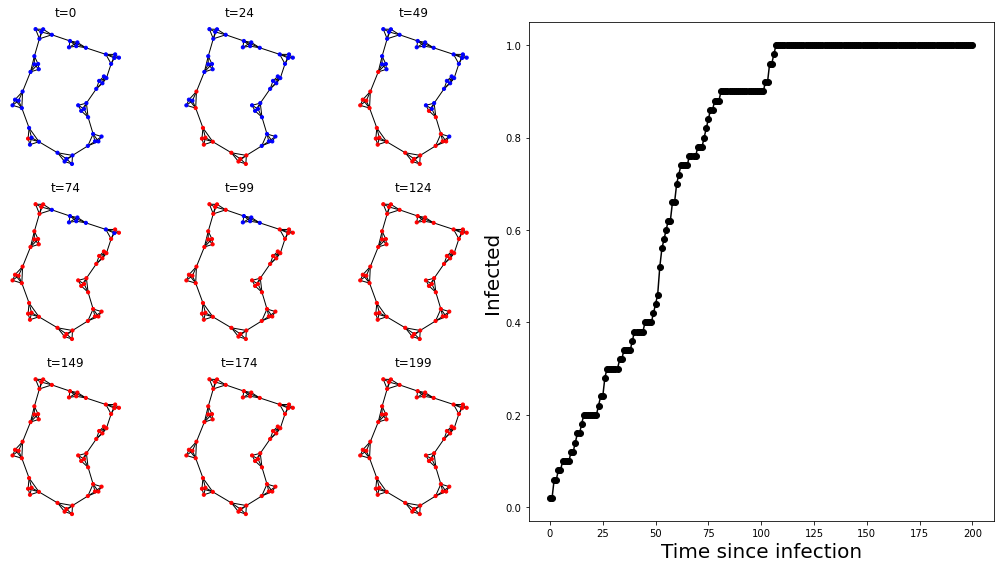

In [25]:
G = nx.connected_caveman_graph(10, 5)
p_I = 0.1
n_iter = 200

I = set()
S = set(G.nodes())

patient0 = np.random.choice(list(S))

I.add(patient0)
S.remove(patient0)

N = len(G.nodes) # List of infected
frac_I = [len(I)/N] # Fraction of infected

def gdraw(G, S, ax):
    nx.draw(G, 
           ax = ax,
           pos = nx.spring_layout(G, seed = 10),
           node_color = ['blue' if n in S else 'red' for n in range(N)], #color infected nodes red
           node_size = 10)

fig = plt.figure(figsize = (14,8))
gs = gridspec.GridSpec(3, 6)
x = 0
y = 0

ax = plt.subplot(gs[x,y])
gdraw(G, S, ax)
ax.set_title('t=0')

for t in range(n_iter):
    for infected_node in list(I):
        neighbors = G.neighbors(infected_node)
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I])
        I |= infected_neighbors
        S -= infected_neighbors
    
    frac_I.append(len(I)/N) # change in infection at time t corresponding to (1)

    if ((t+1)/(n_iter/8)).is_integer():
        y += 1
        if y > 2:
            y = 0
            x += 1
        ax = plt.subplot(gs[x, y])
        gdraw(G, S, ax)
        ax.set_title(f't={t}')   

ax = plt.subplot(gs[:, 3:])
ax.plot(frac_I, 'o-', color = 'black')
ax.set_xlabel('Time since infection', fontsize = 20)
ax.set_ylabel('Infected', fontsize = 20)
plt.tight_layout()

plt.show()

> **Ex. 11.1.6**: Use what you have learned and implement an SIRS model.
* Run it on the Facebook network from last week (so load that into a `networkx.Graph`).
* Record the fraction of infected, susceptiple and recovered over time.
* After the simulation has run, plot these quantities over time and comment on your results
* Be proud of yourself for having solved a really interesting problem.

### Further learning

Since the above exercises teaches you how to write down epidemic models (as systems of differential equations)
and subsequently teaches you how to simulate a spreading process on a network to obtain data on infected/susceptible/recovered
over time, you would think it natural that I also taught you how to fit these epidemic models to such data.
This, however, is going a bit too far as this is not a course in computational epidemiology. But if you want to
figure out how to do it, you literally just need to Google search for "fit SIR model".

And finally, a note on how these models are used in the real world. The state-of-the-art in epidemiological modeling is something called "meta popultion models". They are essentially systems of compartmental models. One component in such a model may be a country, and it has its own little SI, SIR or SIRS model. Components are then coupled because there are people moving between them. The paper *The Hidden Geometry of Complex,
Network-Driven Contagion Phenomena* by Dirk Brockmann and Dirk Helbing published in Science in 2013 ([link here](https://www.dropbox.com/s/hxprfyr51fwh907/brockmann13.pdf?dl=0)) sets up such a model for the world using airline traffic as a proxy for people flow between countries. It is a must read if you
are curious about how the pros predict things like when a disease will arrive in a certain place or where a disease originated. I strongly recommend reading it and understanding the figures, it is a stroke of genius.